# Template for variable length Signalling Game

This template is based on the [MNIST autoencoder tutorial](https://github.com/facebookresearch/EGG/blob/master/tutorials/EGG%20walkthrough%20with%20a%20MNIST%20autoencoder.ipynb) and [signal game implementation](https://github.com/facebookresearch/EGG/blob/master/egg/zoo/signal_game) provided by the [EGG library](https://github.com/facebookresearch/EGG).

Some code is provided by Mathieu Bartels and Liselore Borel Rinkes at the UvA.

Make sure you have a directory `SignalGame` in your Drive!

In [76]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.model_zoo as model_zoo
from tqdm import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import random
import numpy as np
import scipy.spatial.distance as distance
import scipy.stats
import scipy
import egg.core as core
import egg.zoo as zoo

## Configuration
Make sure to define some important configuration parameters in a convenient place, such as the number of images.

In [77]:
import types
import json

# For convenience and reproducibility, we set some EGG-level command line arguments here
opts = core.init(params=['--random_seed=7', # will initialize numpy, torch, and python RNGs
                         '--lr=1e-3', # sets the learning rate for the selected optimizer 
                         '--batch_size=64',
                         '--vocab_size=100',
                         '--max_len=10',
                         '--n_epochs=15',
                         '--tensorboard',
                         ]) 

# Other configurations that are not part of the above command line arguments we define separately. 
# Feel free to use a different format.
_args_dict = {
    "architecture" : {
        "embed_size"      : 64,
        "hidden_sender"   : 200,
        "hidden_receiver" : 200,
        "cell_type"       : 'gru',
    },
    "game" : {
        "num_imgs"        : 2, # number of images the game is played with
    },
    "training" : {
        "temperature"     : 1,
        "decay"           : 0.9,
        "early_stop_accuracy" : 0.97,
    },
}

# A trick for having a hierarchical argument namespace from the above dict
args = json.loads(json.dumps(_args_dict), object_hook=lambda item: types.SimpleNamespace(**item))

print("Cell type of the agents:", args.architecture.cell_type)

# TODO: other configurations?

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Cell type of the agents: gru
Device: cuda


## Vision
In this template we use the [CIFAR-100 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) for the images and use a fixed [pre-trained vision module](https://github.com/chenyaofo/CIFAR-pretrained-models/).
The vision module will encode the images in the dataset before the agents get to see these.
You can also choose to make the vision module part of the agents and update the parameters during playing the game (as in the MNIST tutorial).

In [78]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Vision(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        super(Vision, self).__init__()
        self.inplanes = 16
        self.conv1 = conv3x3(3, 16)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        return x

    def classify(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

# load pre-trained parameters
num_classes = 100
restnet_location = "https://github.com/chenyaofo/CIFAR-pretrained-models/releases/download/resnet/cifar100-resnet56-2f147f26.pth"
vision = Vision(BasicBlock, [9, 9, 9], num_classes=num_classes).to(device)
vision.load_state_dict(model_zoo.load_url(restnet_location))

vision.eval()

Vision(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals

## Data
Implement a custom dataset to be used in the Signalling Game, building on top of a Dataset of your choice.
*You could use the below code to use a featuriser for CIFAR-100 or implement your own!*

In [79]:
transform = transforms.Compose([
    transforms.RandomCrop(size=32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5071, 0.4865, 0.4409],
        std=[0.2009, 0.1984, 0.2023]
    ),
])

cifar_train_set = datasets.CIFAR100('./data', train=True, download=True, transform=transform)

cifar_validation_set = datasets.CIFAR100('./data', train=False, transform=transform)

Files already downloaded and verified


In [80]:
class SignalGameDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, num_imgs, vision, classes=None, seed=1):
        self.dataset = dataset
        self.num_imgs = num_imgs
        self.vision = vision
        
        np.random.seed(seed=seed)
        self.img_features = self._extract_img_features() # (dataset_size, embed_size)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        # get random images
        random_idxs = np.random.randint(low=0, high=self.__len__(), size=self.num_imgs)
        random_imgs = self.img_features[random_idxs]
        # get a random permutation of integers from 0 to num_imgs-1
        permutation = torch.randperm(self.num_imgs)

        # set the target image as the first random image
        sender_imgs = random_imgs[0].unsqueeze(dim=0)
        
        # permute random images for the receiver
        receiver_imgs = random_imgs[permutation]
        
        # set the label
        target = permutation.argmin()
        
        return sender_imgs, target, receiver_imgs

    def _extract_img_features(self):
        """
            We have to have to extract image features by making a forward pass through the pretrained vision model.
            We can't do it for all images at once as there's too many of them and we would run out of memory,
            so we do it in batches.
        """

        # read images from dataset into a single array
        imgs = [img for img, label in self.dataset]
        imgs = torch.stack(imgs)
        
        # if you run out of memory or your laptop freezes, decrease this number and try again
        VISION_BATCH_SIZE = 1000
        vision_loader = torch.utils.data.DataLoader(imgs, shuffle=False, batch_size=VISION_BATCH_SIZE, num_workers=0)

        # extract features from images with a vision model
        img_features = []
        for img in tqdm(vision_loader, desc="Extracting features in batches"):
            img = img.to(device)
            with torch.no_grad():
                img_features.append(self.vision(img))
        img_features = torch.cat(img_features)
        return img_features

print("Extract image features from train set")
trainset = SignalGameDataset(cifar_train_set, args.game.num_imgs, vision)
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=opts.batch_size, num_workers=0) # was 2

print("Extract image features from validation set")
validationset = SignalGameDataset(cifar_validation_set, args.game.num_imgs, vision)
validationloader = torch.utils.data.DataLoader(validationset, shuffle=False, batch_size=opts.batch_size, num_workers=0)

Extract image features from train set


Extracting features in batches: 100%|███████████████████████| 50/50 [00:14<00:00,  3.54it/s]


Extract image features from validation set


Extracting features in batches: 100%|███████████████████████| 10/10 [00:02<00:00,  3.85it/s]


## Agent design
We can use the Rnn Wrappers from EGG to implement a recurrent neural agent on top of your Sender and Receiver design. Here the Gumbel Softmax (GS) is used, but you can also use a [Reinforce Wrapper](https://github.com/facebookresearch/EGG/blob/master/egg/core/reinforce_wrappers.py).

See [RnnSenderGS and RnnReceiverGS](https://github.com/facebookresearch/EGG/blob/master/egg/core/gs_wrappers.py) in the documentation for what happens under the hood.

### Sender

In [15]:
class Sender(nn.Module):
    def __init__(self, embed_size, num_imgs, hidden_sender):
        super(Sender, self).__init__()
        """
            Note: embed_size is also the size of image features extracted from the vision model,
            so the shape of a batch from the SignalGameDataset() is going to be (batch_size, embed_size * num_imgs)
        """
        self.embed_size = embed_size
        self.num_imgs = num_imgs
        self.fc = nn.Linear(embed_size, hidden_sender)
        
    def forward(self, imgs):
        """
        In our setup, the sender only sees the target image. If we wanted to give both target image and distractors to the sender,
        we would replace `imgs.reshape(-1, self.embed_size)` with `imgs.reshape(-1, self.num_imgs*self.embed_size)`
        """
        imgs = imgs.reshape(-1, self.embed_size)
        x = self.fc(imgs).tanh()
        return x

sender = Sender(args.architecture.embed_size, args.game.num_imgs, args.architecture.hidden_sender)

sender = core.RnnSenderGS(sender, opts.vocab_size, args.architecture.embed_size, args.architecture.hidden_sender, cell=args.architecture.cell_type, max_len=opts.max_len, temperature=args.training.temperature, straight_through=True)

### Receiver


In [16]:
class Receiver(nn.Module):
    def __init__(self, hidden_size, embed_size):
        super(Receiver, self).__init__()
        self.fc = nn.Linear(embed_size, hidden_size)

    def forward(self, hidden_state, imgs):
        # hidden_state is the message passed by the sender and is of shape (batch_size, hidden_size)
        # imgs is of shape (batch_size, num_imgs, embed_size)
        embed_imgs = self.fc(imgs).tanh() # (batch_size, num_imgs, hidden_size)
        
        hidden_state = torch.unsqueeze(hidden_state, dim=-1) # (batch_size, hidden_size, 1)

        # (batch_size, num_imgs, hidden_size) x (batch_size, hidden_size, 1) = (batch_size, num_imgs, 1)
        # because (num_imgs, hidden_size) x (hidden_size, 1) = (num_imgs, 1)
        energies = torch.matmul(embed_imgs, hidden_state) 

        return energies.squeeze() # (batch_size, num_imgs)

receiver = Receiver(args.architecture.hidden_receiver, args.architecture.embed_size)

receiver = core.RnnReceiverGS(receiver, opts.vocab_size, args.architecture.embed_size,
                    args.architecture.hidden_receiver, cell=args.architecture.cell_type)

## Loss function

In [17]:
def loss(_sender_input,  _message, _receiver_input, receiver_output, _labels):
    acc = (receiver_output.argmax(dim=1) == _labels).detach().float()
    loss = F.cross_entropy(receiver_output, _labels, reduction="none")
    # print('Loss: ', loss.mean().cpu().item(), 'Acc: ', acc.mean().cpu().item())
    return loss, {'acc': acc}

## Game setup and training
Use `core.SenderReceiverRnnGS` for creating a variable message length game, set the optimizer and other options, and start training the agents.

In [18]:
%load_ext tensorboard

In [19]:
model_prefix = f"maxlen_{opts.max_len}" # Example
models_path = "/content/drive/My Drive/SignalGame/models" # location where we store trained models

checkpointer = core.callbacks.CheckpointSaver(checkpoint_path=models_path, checkpoint_freq=0, prefix=model_prefix)

In [20]:
game = core.SenderReceiverRnnGS(sender, receiver, loss)
optimizer = torch.optim.Adam(game.parameters())

callbacks = [core.TemperatureUpdater(agent=game.sender, decay=args.training.decay, minimum=0.1),
             core.ConsoleLogger(as_json=True, print_train_loss=True),
             core.TensorboardLogger(),
             core.EarlyStopperAccuracy(args.training.early_stop_accuracy),
             checkpointer]

trainer = core.Trainer(
    game=game, optimizer=optimizer, train_data=trainloader,
    validation_data=validationloader, callbacks=callbacks)

In [21]:
trainer.train(n_epochs=opts.n_epochs)

{"loss": 0.29803892970085144, "acc": 0.8338599801063538, "length": 7.530139923095703, "mode": "train", "epoch": 1}
{"loss": 0.16294455528259277, "acc": 0.9171000123023987, "length": 8.18690013885498, "mode": "test", "epoch": 1}
{"loss": 0.1451311558485031, "acc": 0.9274399876594543, "length": 8.542619705200195, "mode": "train", "epoch": 2}
{"loss": 0.10232457518577576, "acc": 0.9528999924659729, "length": 8.155099868774414, "mode": "test", "epoch": 2}
{"loss": 0.09853953868150711, "acc": 0.9538999795913696, "length": 7.04856014251709, "mode": "train", "epoch": 3}
{"loss": 0.08425280451774597, "acc": 0.9613999724388123, "length": 6.052299976348877, "mode": "test", "epoch": 3}
{"loss": 0.06785829365253448, "acc": 0.9699400067329407, "length": 7.7115797996521, "mode": "train", "epoch": 4}
{"loss": 0.05962985381484032, "acc": 0.9725000262260437, "length": 7.402100086212158, "mode": "test", "epoch": 4}


I checked and setting the random seed works correctly - the results are exactly the same for two attempts with the same seed.

In [22]:
%tensorboard --logdir ./runs

ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 23308.

## Evaluation of the emergent languages
Next up, start analysing the languages and other behaviour you are interested in.

In [23]:
from egg.zoo.objects_game.util import dump_sender_receiver
# Check out https://github.com/facebookresearch/EGG/blob/aba2489e78f0b6e202bf2c6138fde41bf9056cb5/egg/zoo/objects_game/util.py

sender_inputs, messages, receiver_inputs, receiver_outputs, labels = dump_sender_receiver(game, validationloader, True, variable_length=True, device=device)
messages = [message.cpu().numpy() for message in messages]
for m in messages:
    print(str(m))

[25 11 11 25 11 11 11  0]
[68 68 68 77 68 68 77 68 68 25  0]
[68 68 68 77 68 68 68 77 82 77  0]
[77 77 82 77 77 82 77 77 82 77  0]
[77 82 82 82 77 82 82 82 82 82  0]
[25 25  0]
[82 82 82 82 82 82 82 82 82 82  0]
[25 25 25 25 25 25 25 11 25 11  0]
[72 68 25 62 11 11 11 11 11  0]
[68 82 77 82 77 82 77 82 77 82  0]
[72 62 82  0]
[11  0]
[62  0]
[85 11  0]
[77 68 25 82 25 11 11 11 11 11  0]
[11 11  0]
[72  0]
[68 77 82 77 68 68 77 82 11 68  0]
[85 11 62 11 11 82 11 82  0]
[72  0]
[11 82 77 82 11 82 82 82 11 82  0]
[82 82 82 82 82 82 82 82 82 82  0]
[82 82 82 82 11 82 82 82 82 82  0]
[68 77 82 77 82 11 82 77 82 82  0]
[25 25 62 62 62 11  0]
[82 11 11 11 11 11 11 11 82 11  0]
[77 82 77 82 82 82 82 82 82 82  0]
[72 62  0]
[82 82 77 82 82 77 82 82 77 82  0]
[72  0]
[72 77 82 77 82 82 77 82 82 82  0]
[72  0]
[72 62 82 62 82 82 82 82  0]
[82 77 82 77 82 82 77 82 82 77  0]
[72 72 82 72 82 82 72 82 82 82  0]
[72  2 72 82 82 62 62 82 82 82  0]
[72  0]
[68 25 11 11 11 11 11 25 11 11  0]
[68 68 68 68

[82 11 82 82 77 82 82 82 82 82  0]
[11 62 11 82  0]
[11 11  0]
[25 62 62 11  0]
[82 82 82 82 82 82  0]
[11  0]
[72  2 82 85 82 82 82 82 82 82  0]
[77 82 77 82 77 82 77 82 77 82  0]
[11 11 11 82 11 11 11 82 11 11  0]
[68 25 68 25 68 25 68 25 11 11  0]
[85 62 11  0]
[72  2 62 62 62 82 62 11 82 11  0]
[68 25 11 11 62 62 62 11 11 11  0]
[85 62 62 11  0]
[25 25 25 25 25 25 11 25 11  0]
[25 25 82 25 68 25 82 11 62 11  0]
[82 82 82 82 82 82 82 82  0]
[25 68 25 68 11 11 25 11 11 11  0]
[72  0]
[82 82 77 82 82 82 82 82 82 11  0]
[11 11 82 11 82 82 82 82 82  0]
[25 25 68 25 25 11 25 11 11  0]
[82 82 82 82 82 11 82 82 82 82  0]
[82 82 77 82 82 82 82 77 82 82  0]
[72  0]
[68 25 11 11 11 25 11 11 11 11  0]
[72  0]
[82 82 82 82 82  0]
[11 62 62 62 62 11  0]
[62 11  0]
[82 82 82 82 82 82  0]
[11 11 11  0]
[72 68 77 25 68 25 77 68 25 25  0]
[72 68 77 68 77 82 11 68 82 77  0]
[72  0]
[68 68 68 77 82 68 77 82 68 77  0]
[72  0]
[68 68 68 68 68 68 25 82 11 68  0]
[72  0]
[72 77 82 72 82 25 68 25 82 11  0]

[25 62 62 62 11 11  0]
[11 11 11 11 82  0]
[72  0]
[11  0]
[72  0]
[25 25 25 25 11 25 25 11 11  0]
[25 25 68 25 25 25 68 25 25 11  0]
[82 82 11 82 82 11 82 11 82 82  0]
[72  0]
[72  0]
[25 25 25 25  0]
[85  0]
[82 82 82 82 82 82 82 82  0]
[82 68 68 68 68 68 68 68 68 68  0]
[68 68 68 25 68 11 11 11 11 11  0]
[11 11 11 11 11 82 11 11 82 11  0]
[25 25 11 62 62 62 11  0]
[11 11 11 11 82 11 82 11 82 82  0]
[82 11 11 82 11 82 11 82 11 82  0]
[11 11 11 11 82 11 11 11 11 82  0]
[82 82 11 82 82 11 82 82 82 82  0]
[72 25 62 62 11 11  0]
[72 25 11  0]
[11 11 11 11 11 11 11 82 11 82  0]
[82 68 82 68 68 82 68 68 68 82  0]
[82 82 11 82 77 82 82 11 82 82  0]
[72 72 82 72 82 82  0]
[72 82 72 82 11 82 82 82  0]
[11  0]
[25 25 68 25 68 25 11 11 25 11  0]
[11 11 11 11 11 11 11 62 11 11  0]
[72  0]
[25 68 25 68 25 11 25 11 11 11  0]
[11 11 11 11 62 62 62 11  0]
[25 25  0]
[68 11 11 11 11 11 11 11 11 11  0]
[77 82 77 82 77 82 82 82 82 82  0]
[85 11 11 11 11 11 11 82  0]
[25 25 25 25 25 25 25 25 25 25  0]
[

[72 82 85 82 82 82 11 82 82 82  0]
[77 82 77 82 77 82 82 77 82 82  0]
[82 11 11 82 82 11 82 82 82 82  0]
[82 82 82 82 82 82 82  0]
[72  0]
[72  0]
[68 25 68 25 11 11 11 25 11 11  0]
[68 68 68 25 68 68 25 68 68 25  0]
[82 77 82 82 77 82 82 77 82 82  0]
[11 11 11 11 82  0]
[77 82 77 82 77 82 77 82 77 82  0]
[11 11 11 11 11 11 11 11 11 11  0]
[68 77 68 77 68 73 68 73 77 68  0]
[82 82 82 11 82 11 82 82 11 82  0]
[77 68 77 77 68 25 68 25 68 25  0]
[82 82 82 82 82  0]
[11  0]
[82 11 82 82 82  0]
[72  0]
[72 62 82 62 82 82 82 82  0]
[72 72 82 72 82 82 72 82 82 82  0]
[72  0]
[82 68 82 68 68 82 77 82 11 11  0]
[72  0]
[11 82  0]
[25  0]
[11  0]
[72  0]
[82 82 82 82 82 77 82 82 82 82  0]
[72  0]
[77 77 77 68 25 68 25 68 25 68  0]
[72  2 82 82  0]
[82 82 82 82 82  0]
[25 68 25 25 11 25 11 11 11 11  0]
[25 68 25 68 25 11 25 11 11 62  0]
[82 82 82  0]
[11 11 11 11 11 11 82 82  0]
[0]
[82 68 68 68 82 77 82 11 82 11  0]
[82 11 82 82 82 82 82 11  0]
[11 62 11  0]
[82 82 82 82 82 82  0]
[72 62 82  0]


[82 11 82 11 82 82 82 82 82 82  0]
[77 82 77 82 77 82 77 82 82 11  0]
[11 11 11 11 11 11 11 11 11 11  0]
[82 11 82 82 82 11 82 82 82 82  0]
[82 68 68 82 77 82 82 11 82 11  0]
[72  0]
[82 82 82 82 82 82 82  0]
[72  0]
[82 82 82 82 11 82 82 82 82 11  0]
[25 62 62 62 11  0]
[82 11 82 82 11 82 82 11 82 82  0]
[68 68 68 68 25 68 68 11 68 25  0]
[82 82 11 82 11 82 82 11 82 82  0]
[72  0]
[72 72 82  0]
[72 72  2 62 82  0]
[85 62 11 82 82  0]
[72  0]
[68 11 82 11 68 11 82 77 82 11  0]
[72 72 82 82 82 82  0]
[82 82  0]
[82 82 82 77 82 82 82 82 82 82  0]
[72  2 25 62 11 11 82  0]
[25 62 62 11 11  0]
[25 25 62 62 11 11  0]
[68 77 68 77 68 68 77 68 68 77  0]
[68 68 68 77 68 68 77 68 68 25  0]
[72  0]
[68 25 68 25 25 68 25 25 68 25  0]
[68 82 77 82 82 77 82 82 77 82  0]
[82 11 82 11 82 11 11 82 11 11  0]
[82 11 82 82 11 82 11 82 11 82  0]
[25 11 62 62 11 11  0]
[11 11 11 82 11 82 82 82 82 82  0]
[11 11 82  0]
[11 11 62 11 11  0]
[62 62 62 62 82 11  0]
[72  0]
[11 11 11 62 62 11 11  0]
[72 25 25 62 

[72  0]
[68 68 25 68 68 68 25 68 68 11  0]
[82 82 82 82 82 82 82 82  0]
[11 11 82 11 82 82  0]
[72 72  2 72 82 82  0]
[82 11 68 82 11 68 11 82 11 68  0]
[25 25  0]
[82 82 82 82 82 82 82 82  0]
[68 25 11 11 25 11 11 11 25 11  0]
[11  0]
[82 82 82 11 82 82 82 82 82 82  0]
[85 62 82 82 82 82  0]
[25 25 62 11 11  0]
[11 82 82 82 82 82 82  0]
[72 68 62 68 62 62 82 62 62 82  0]
[82 82 77 82 82 82 77 82 82 82  0]
[72  0]
[82 82 82 82 82 82 82 82 82 82  0]
[82 82 82  0]
[85 62 62  0]
[11  0]
[68 68 68 68 11 68 68 11 68 11  0]
[72  0]
[68 68 68 68 68 68 68 68 68 25  0]
[11 11 11 11 82  0]
[82 82 82 82 82 82 82 82 82 82  0]
[72  0]
[82 82 82 82 82 82 82 82  0]
[68 68 68 68 11 68 11 68 25 68  0]
[72 25 62 82 11  0]
[25 25 25 25 25 25 11 25 11 11  0]
[72  0]
[72  0]
[25 62 11 11 11 82  0]
[82 11 11 82 11 82 11 82 82 11  0]
[77 82 77 77 82 77 68 77 68 77  0]
[25 62 62 62 11 11 11  0]
[82 82 82 11 82 11 82 11 82 11  0]
[85 85 82 77 82 82 82 82 82 82  0]
[25 11 62 62 62 11  0]
[77 82 77 82 77 82 77 8

[68 68 25 82 25 68 68 68 25 68  0]
[11  0]
[72  0]
[68 77 82 77 68 68 77 82 77 82  0]
[72  0]
[72 82 77 77 82 77 77 82 77 82  0]
[25 25 62 62 11  0]
[82 82 82 82 82 82 11 82 82 82  0]
[77 82 77 82 77 82 77 82 77 82  0]
[82 11 82 82 82  0]
[11 11 11 11  0]
[25 68 25 68 25 68 25 25 82 25  0]
[85 85 62 82  0]
[72  0]
[68 68 77 68 68 77 68 68 68 77  0]
[25 62  0]
[11 11  0]
[77 82 77 82 77 82 77 82 77 82  0]
[85 25 11 11 11 11 11 11 11 11  0]
[72  2 62 82 82 82 82 82  0]
[82 68 82 11 68 82 11 11 11 82  0]
[77 77 82 77 82 77 82 77 82 77  0]
[85 85 62 82 82  0]
[82 77 82 82 77 82 82 82 82 82  0]
[85 85 82 77 82 82 82 82 82 82  0]
[72  0]
[82 82 68 68 82 68 68 82 77 82  0]
[25 25 62 62 11  0]
[11 11 82 77 82 11 82 11 82 11  0]
[11 11 82  0]
[82 82 11 82 82 82 82  0]
[82 82 77 82 82 82 82 82 82 82  0]
[72  0]
[72 68 77 82 62 11 82 62 82 82  0]
[82 82 77 82 82 82 77 82 82 82  0]
[25 11 11 25 11 11 25 11 11 11  0]
[82 82 82  0]
[62 62 11 11  0]
[25 25 25 62  0]
[25 11 62 62 62 11  0]
[82 11 11 1

[11 25 11 11 11 11 62 11 11 11  0]
[82 77 82 82 11 82 82 11 82 82  0]
[25 25 25 25  0]
[11 11 11 82 11 11 11 82 11 82  0]
[68 25 68 68 25 68 25 68 25 11  0]
[72 25  0]
[11 11 11 11 82 11 11 11 11 82  0]
[82 82 82 77 82 82 82 82 82 77  0]
[68 25 68 68 25 68 25 68 25 11  0]
[25  0]
[72  0]
[68 25 68 25 68 25 68 25 68 25  0]
[82 82 82 82 11 82 82 82 82 82  0]
[11 25 11 62 62 11  0]
[82 82 82  0]
[72  0]
[68 11 68 11 11 68 11 11 11 11  0]
[82 82 82 82 82 82  0]
[82 82 82 82 77 82 82 82 82 82  0]
[85 62 62 11 11 11 82 11  0]
[82  0]
[11 11 11 11 82  0]
[85 62 11  0]
[25 25  0]
[72 72 62 82  0]
[85 85 62 82 11 82 82  0]
[82 82 82 82  0]
[82 82 82 82 77 82 82 82 82 82  0]
[72  0]
[82 82 82 82 82 82 82 82  0]
[82 82 82 11 82 11 82 11 82 82  0]
[82 68 68 82 68 68 68 68 11 68  0]
[77 82 77 82 82 82 82 77 82 82  0]
[82 82 82 82 82 82  0]
[82 68 68 82 77 82 77 82 82 11  0]
[82  0]
[25  0]
[82 82 82 82 82 77 82 82 82 82  0]
[77 82 77 82 77 82 77 82 77 82  0]
[85  0]
[11 11 11  0]
[68 82 77 82 77 82

[72 25 25 62 11 11  0]
[82 82 82 82 82  0]
[25 62 62 62 11  0]
[72  0]
[25 25 68 25 25 25 25 25 25 68  0]
[82 77 82 82 77 82 82 82 82 77  0]
[72 82 77 82 77 82 82 82 82 82  0]
[72  0]
[85 77 82 82 82 11 82 82 82 82  0]
[72 62 11  0]
[82 11 11 82 11 11 11 82 11 11  0]
[85 62 82  0]
[82 82 82 82  0]
[82 82  0]
[72  0]
[72  0]
[82 11 82 82 82 11 82  0]
[72  0]
[82 82 77 82 82 82 82 11 82 82  0]
[68 11 11 11 11 11 11 11 11 62  0]
[82 82 82 82 82 82 82 82 82 82  0]
[82 11 82 82 77 82 82 82 11 82  0]
[68 77 82 77 82 82 77 82 82 77  0]
[68 68 68 77 68 68 77 68 68 25  0]
[11 11 25 11 11 11 11 11 11 11  0]
[82 82 82 82 82 77 82 82 82 82  0]
[72  0]
[72 25 62 11  0]
[25 62 11  0]
[68 25 68 25 25 68 25 25 68 25  0]
[82 82 82 82 82 82 82 82 82 82  0]
[82 82 11 82 11 82 82 77 82 82  0]
[25 62 62 62 11  0]
[72 62 62 62 11  0]
[11 11 11 82 82  0]
[72  0]
[82 82 82 82 11 82 68 82 11 82  0]
[82 82 82 68 82 82 68 82 77 82  0]
[72  0]
[72  2 62 82 82  0]
[82 11 11 82 11 11 11 11 82 11  0]
[72  0]
[72  0]

[25 62 62 11  0]
[85 62 62 11 11 82  0]
[11 11 11 11 11 11 11 11 11 11  0]
[11 11 11 11 11 11 11 62 62 11  0]
[82 82 82 82 82 82 82 82 82 82  0]
[68 77 82 77 82 77 82 77 82 77  0]
[72 72 68 25 62 11 11  0]
[25 68 25 68 25 68 25 11 11 25  0]
[82 11 11 11 11 82 82 11  0]
[85 85 62 82 82 82  0]
[68 11 11 11 11 11 11 11 11 11  0]
[72  2 62 62 82 82  0]
[11 62 62 11 11 62 11 11 11 11  0]
[82 82  0]
[77 82 77 82 82 82 77 82 82 82  0]
[72 25  0]
[25 62 62 62 11  0]
[82 82 82 82  0]
[77 68 68 77 82 77 82 11 68 11  0]
[72  0]
[11 11 11 11 62 11 11  0]
[25 11 25 11 11 25 11 11 11  0]
[25 25 62  0]
[77 82 77 77 82 77 82 77 82 77  0]
[68 68 68 68 25 68 68 68 25 68  0]
[68 68 68 68 68 68 68 77 82 68  0]
[72 72 82 72 82 97 62 82  0]
[72  2 62 82 82  0]
[82 82 82 82 82 82 82  0]
[77 82 77 82 82 77 82 82 82 82  0]
[72  0]
[72 72 62  0]
[72 62  0]
[72  0]
[82 82 82 11 82 82 82 82 82 82  0]
[82 82 11 11 82 11 82 11 82 82  0]
[11 11 11 11 11 11 11 11 11 11  0]
[77 77 82 77 82 11 68  8 82 11  0]
[85 25 62

[77 68 11 68 77 68 11 82 11 68  0]
[82 77 82 77 82 77 82 82 77 82  0]
[72  0]
[82 82 82  0]
[77 77 77 77 77 68 25 77 68 25  0]
[72  0]
[77 68 68 77 82 77 82 77 82 68  0]
[68 68 68 25 82 11 25 11 11 11  0]
[82 82 82 82 82 82 82  0]
[82 82 11 11 82 11 82 11 82 82  0]
[72 77 82 25 77 68 25 82 25 25  0]
[82 68 68 82 68 68 68 68 11 68  0]
[68 11 11 11 11 11 11 11 11 11  0]
[82 82 82 82 82 82 82 82 82 82  0]
[82 82 11 82 11 82 82 11 82 11  0]
[68 68 68 68 68 68 68 68 11 68  0]
[68 82 77 82 77 82 77 82 82 77  0]
[77 82 11 82 77 82 82 82 11 82  0]
[72  0]
[11 11 11 11 11 11 11 11 11 11  0]
[72  2 77 62 82 62 82 11 82 82  0]
[82 77 82 11 82 11 82 11 82 82  0]
[11 11 62 11 82 82  0]
[82 82 77 82 82 82 82 77 82 82  0]
[68 68 68 68 68 68 68 68 68 68  0]
[68 77 82 77 82 82 77 82 11 82  0]
[85 62 82 11 82 82  0]
[72  0]
[82 82 82  0]
[72  0]
[11 11 11 11 11 11 82 11 11 82  0]
[72  2 77 82 82 82 82 82  0]
[11 11 11 11 82 11 11 82 11 11  0]
[25 62 62 11  0]
[72  0]
[82 77 82 82 77 82 82 77 82 82  0]
[

[72 25 11 11  0]
[11  0]
[72 72 62 62 82  0]
[68 77 82 11 77 82 11 68 11 82  0]
[72  0]
[77 77 77 82 77 68 77 68 77 68  0]
[72  2 62 82 82 82  0]
[72  0]
[11 11  0]
[82 82 11 82 82 82 82 82 82 82  0]
[82 77 82 77 82 77 82 77 82 77  0]
[11  0]
[77 77 82 77 77 82 77 82 77 82  0]
[82 68 82 68 68 82 77 82 11 11  0]
[72  0]
[72 68 77 77 82 77 68 77 82 62  0]
[11 62 62 62 11  0]
[25 25 11  0]
[77 68 68 77 68 68 68 77 82 11  0]
[11 11 11 11 11 11 11 11 11 11  0]
[82 82 77 82 82 77 82 82 77 82  0]
[72  0]
[72  0]
[85  0]
[25 68 25 68 25 68 25 68 25 68  0]
[82 82 82 82 82 82 82 82 82 82  0]
[72  0]
[77 77 82 77 82 77 82 77 82 82  0]
[68 25 68 25 11 11 11 25 11 11  0]
[82 82 11 82 82 11 82 82 82 82  0]
[11 11 11 11 11 11 11  0]
[82 82 82 82 82 82  0]
[11 62 11 82  0]
[72 72 62  0]
[72 68 25 25 82 25 25 82 25 11  0]
[25  0]
[72 72 82  0]
[11  0]
[72 62  0]
[72  0]
[25 25 11 25 25 11 11 62 62  0]
[72  0]
[25 25 68 25 68 25 25 68 25 11  0]
[11 11 11 82 11 11 11 11 82 11  0]
[82 68 68 68 68 11 68 68

[68 82 68 68 68 68 68 68 68 68  0]
[25 25 62 62  0]
[11 11 11 11 11 11 11 11 11 11  0]
[82 11 82 82 82 82 82 82  0]
[77 77 82 25 82 25 82 11 11 82  0]
[82 82 77 82 82 77 82 82 77 82  0]
[72 72 62 11  0]
[72  0]
[68 11 11 11 11 11 11 11 11 11  0]
[82 82 82 82 82 82 82 82 82 82  0]
[72  0]
[68 11 82 11 11 11 82 11 11 11  0]
[11 11 25 11 11 11 62 11 11 11  0]
[85 62  0]
[25 25 25 25  0]
[11  0]
[82 82 82 82 82 82 82  0]
[72  2 72 82 82 11 82  0]
[85 11 62 11 11 82 11 82  0]
[25 25 62  0]
[25 68 25 11 25 11 11 25 11  0]
[72 25 68 25 25 82 25 25 11 11  0]
[82 68 68 68 68 68 11 68 68 11  0]
[77 68 77 68 77 68 77 68 77 68  0]
[25 11 25 11 62 11 11 11  0]
[72 62 82 62 82 11 82 82 82 82  0]
[72  0]
[11 62 62 11 11 82  0]
[68 68 77 82 82 77 82 82 11 82  0]
[68 11 77 82 11 82 11 82 11 82  0]
[72  0]
[68 68 25 68 68 25 68 68 25 68  0]
[25 62 62 62  0]
[68 11 11 11 11 11 11 11 11 11  0]
[72 72 62  0]
[11 11 11 11 11 62 11 62 62 11  0]
[82 11 11 82 11 11 11 82 11 11  0]
[82 68 82 68 68 82 68 68 68 6

[77 82 77 82 77 82 77 82 82 77  0]
[85 62 62 11  0]
[25 68 25 25 68 25 25 11 25 11  0]
[25 68 25 68 25 25 68 25 11 25  0]
[72 72 62  0]
[11  0]
[72 72  2 72 11 82  0]
[82 68 82 11 68 82 11 68 68 82  0]
[82 68 82 77 82 82 77 82 82 82  0]
[72  0]
[68 68 11 68 11 68 25 11 11 11  0]
[11 11 11  0]
[72 77 82 72 82 77 82 11 82 11  0]
[72  0]
[82 77 82 82 82 77 82 82 11 82  0]
[72  0]
[72 85 62 82  0]
[68 25 11 11 11 11 11 11 11 11  0]
[85 62  0]
[11  0]
[25 25 11 62 62 11 11  0]
[82 82 77 82 82 77 82 82 82 82  0]
[82 82 82  0]
[72  0]
[25 25 25 25 62  0]
[82 77 82 77 82 77 82 82 77 82  0]
[25 25 25 11 62 62  0]
[82 11 82 82 11 82 82 82 82  0]
[72 72  0]
[25 25 68 25 11 11 11 62 11  0]
[62 62 62  0]
[72  0]
[68 68 68 68 68 68 68 11 68 68  0]
[72  0]
[85 62 11 82 82  0]
[25 62 62 62  0]
[62 62 11  0]
[11 11 11 11 11 11 11 82 82  0]
[72 72 72 82  0]
[11 11 25 11 11 11 11 11 11 11  0]
[68 11 11 11 11 11 11 11 11 62  0]
[72  0]
[82 77 82 68 77 82 77 82 82 77  0]
[82 82 82  0]
[82 82 82 82 82 82 82

[85 82 11 82 82 82 82 82  0]
[82 11 82 11 82 11 82 82 82 11  0]
[25 25 82 25 25 11 11 11 62 11  0]
[72  0]
[77 77 77 82 77 77 82 77 77 82  0]
[82 11 11 82 82 82 82 82  0]
[11 11  0]
[82 77 82 82 82 77 82 82 82 82  0]
[25 25  0]
[11 11 62 62 62 62 11 11 11  0]
[82 82 82 82 82 82  0]
[82 11 11 82 11 11 11 82 11 11  0]
[11 11 82 11 82 82 82 82 82  0]
[68 11 11 11 11 25 11 11 11 11  0]
[68 77 82 77 82 77 82 77 82 77  0]
[68 25 68 68 25 68 11 25 11 11  0]
[68 25 68 25 68 25 68 25 68 25  0]
[82 82 82 82 82 82 82 82 82 82  0]
[82 82 82 82 82 82 82 82 82 77  0]
[85 62 11 11  0]
[82 82 82 82 82 82 82  0]
[82 77 82 77 82 82 77 82 82 77  0]
[72  2 72 82 82 11  0]
[85 62 11  0]
[85 25 62 82 11 11  0]
[25 25 62 62 11  0]
[11 82 11 82 82 82 82 82 82 82  0]
[85 11 82 82 82 82  0]
[72  0]
[82 82 82 77 82 82 82 82 82 82  0]
[72 72 62 82  0]
[72  0]
[82 82  0]
[77 77 82 77 77 82 77 77 82 77  0]
[85 62 82  0]
[77 82 77 82 11 82 77 82 82 82  0]
[77 82 82 77 82 82 82 82 82 82  0]
[72 25 62 62 11  0]
[85 11

[68 68 68 68 68 68 25 68 68 11  0]
[25 25 82 25 11 11 11 82  0]
[11 11  0]
[11 11 62 62 62 11 11  0]
[68 25 82 25 11 11 11 11 11 11  0]
[77 82 11  8 11 82  8 11 11 82  0]
[11  0]
[77 68 77 68 77 68 77 68 77 82  0]
[82 11 82 11 82 11 11 82 11 82  0]
[11 11  0]
[25 62 62 11  0]
[82 82 82 11 82 11 82 11 82 82  0]
[72  0]
[11  0]
[82 11 82 11 82 82 11 82  0]
[72  0]
[25  0]
[68 68 68 82 77 82 68 68 68 68  0]
[82 77 82 82 77 82 82 77 82 82  0]
[82 82 82  0]
[11 11 11  0]
[72  0]
[11 11 11 82 11 11 82 82 82  0]
[11 11 11 11 11 11 62 11 11  0]
[72 72 25 62  0]
[25 25 25 25  0]
[25 25 25 11  0]
[11 11 11 11  0]
[11 11 11 11 82  0]
[11 11 62 62 62 62 11  0]
[72  0]
[82 82 82 82 82 82 77 82 82 82  0]
[85 85 82 62 82 82 82 82  0]
[82 77 82 77 82 77 82 82 77 82  0]
[25 25 62 62 11  0]
[82 11 82 11 82 11 82 11 82 11  0]
[82 82 82 82 82 82 82 82  0]
[11 11 82 82 82 82  0]
[72 72 82  0]
[72 72 82 72 82 82 82 82 11  0]
[72 72 72 82 72 82 72 82  0]
[68 25 68 25 68 25 25 68 25 68  0]
[68 68 68 68 11 68 

[77 82 77 68 82 77 82 11 68 68  0]
[25 68 25 25 68 25 11 25 11 62  0]
[82 77 82 77 82 77 82 82 77 82  0]
[72  0]
[11  0]
[82 82 77 82 82 82 82 82 77 82  0]
[72  0]
[72  0]
[11 11 11 82  0]
[82 77 82 82 82 82 82 82 82 82  0]
[82 82 82 82 82 77 82 82 82 82  0]
[68 77 82 82 77 82 82 82 11 82  0]
[85 85 82 11 82 82 82 82  0]
[77 77 82 77 82 77 82 77 82 77  0]
[82 77 82 77 82 82 82 77 82 82  0]
[77 77 82 77 68 11 68 82 11 68  0]
[11 25 11 62 62 62 11  0]
[82 11 82 11 82 82 82 82 11 82  0]
[82 77 82 82 82 82 82 82 82 82  0]
[25 25  0]
[72 72  2 72 82  0]
[82 82 82 82 82  0]
[72  0]
[77 82 77 82 82 82 77 82 82 82  0]
[82 82 82 82 82 11 82 82 77 82  0]
[11 11  0]
[77 82 77 82 77 82 82 77 82 82  0]
[72 77 77 77 82 72 82 77 82 72  0]
[25 62 11  0]
[72  2 25 82 25 11 82 11  0]
[82 82 77 82 82 82 77 82 82 82  0]
[68 82 77 82 77 82 77 82 77 82  0]
[25 25 62 62  0]
[82 77 82 82 77 82 11 82 11 82  0]
[11 11 11 82 11 11 11 11 11 11  0]
[82 11 82 82 11 82 82 82 82 82  0]
[82 11 11 82 82 82 82 82  0]
[1

[72 82 77 77 82 77 77 82 77 82  0]
[25 62 62 11  0]
[68 25 11 11 11 25 11 11 11 11  0]
[72 72 82  0]
[77 68 25 68 68 25 68 68 25 82  0]
[82 82 11 82 82 11 82 82 82 82  0]
[11 11 82  0]
[72  2 72 82 82 97 82 62 82 82  0]
[25 25  0]
[77 77 82 77 82 77 82 82 82 77  0]
[25 62 62 62  0]
[82 82 82 82 82 68 82 68 82 82  0]
[72  0]
[82 82 82 82 82 82 77 82 82 82  0]
[25 25 25 25 25 11 25 11 11  0]
[68 68 68 77 68 68 68 77 68 68  0]
[77 77 82 77 82 82 82 82 77 82  0]
[82 77 82 82 82 82 82 82 82 82  0]
[72  0]
[82 82 82 77 82 82 82 82 77 82  0]
[82 82 82 82 82 82 82  0]
[11 11 82 82 82  0]
[72 77 82 77 77 82 77 82 77 82  0]
[72  0]
[68 11 11 11 11 11 11 11 25 11  0]
[25 25 62 62 62 11  0]
[72 68 77 82 62 11 82 62 82 82  0]
[82 82 82 77 82 82 82 82 82 82  0]
[68 68 77 82 11 68 68 68 68 77  0]
[82 82 11 82 11 82 82 11 82 11  0]
[11  0]
[11  0]
[82 82 82 77 82 82 82 82 77 82  0]
[72  0]
[25 25 25 25 11 25 11 11  0]
[77 82 77 77 82 77 82 77 82 77  0]
[25 62  0]
[77 82 82 77 82 82 77 82 82 82  0]
[82

[68 25 68 25 68 25 68 25 25 68  0]
[11 11 11 11 82  0]
[68 25 68 68 25 68 25 68 68 25  0]
[11  0]
[68 25 11 11 11 25 11 11 11 11  0]
[82 11 82 11 82 11 82 11 82 11  0]
[72 25 25  0]
[77 82 77 82 82 11 82 77 82 82  0]
[77 82 77 82 77 82 82 77 82 82  0]
[68 68 68 68 68 68 25 82 11 11  0]
[82 77 82 77 82 68 77 82 11 68  0]
[82 82 11 82 11 82 11 82 82 11  0]
[77 68 77 82 77 82 11 11 11 11  0]
[72  0]
[11 11 11 11 11 11 11 11 11 11  0]
[72 62 82 82  0]
[25 25 25 25 68 25 25 25 11 25  0]
[72  0]
[72  2 77 82 77 82 25 82 11 11  0]
[85 77 82  8 11 82  8 82 11 82  0]
[25 25  0]
[11 82  0]
[25 25 62 62  0]
[82 82  0]
[85 11 11 11 11 11 11 82  0]
[82 77 82 77 82 82 77 82 77 82  0]
[82 82 82 82 82 77 82 82 82 82  0]
[82 82 82 82 68 82 82 77 82 82  0]
[25  0]
[72  0]
[82 82 82 82 82 82 82  0]
[72 72 72 82 72 72 82 53 11  0]
[11 11 82 11 11 11 11 82 11 82  0]
[68 11 62 11 11 11 11 11 11 82  0]
[11 11 11 11 11 82 11 11 11 11  0]
[82 82 77 82 82 77 82 82 77 82  0]
[72 25 68 25 11 11 62 62 11  0]
[72  

[11 11 11 11 11 11 11 62 11 11  0]
[25 68 25 68 25 68 25 11 25 11  0]
[82 82 77 82 82 82 82 82 82 82  0]
[82 82 82 68 82 77 82 82 82 11  0]
[62 62 62 11 11  0]
[72  0]
[82 82 68 82 77 82 82 11 82 11  0]
[72 82 72 82 11 11 82 11 82 82  0]
[11 11 11 11 11 11 11 82 11 11  0]
[85 62 82  0]
[25 25 25 25 11 25 11 25 11  0]
[72 25 68 25 25 25 11 11  0]
[72 77 82 77 82 82 77 82 82 82  0]
[72  0]
[11  0]
[82 82 82 82 82 82  0]
[11 11  0]
[68 25 68 25 25 68 25 25 25 68  0]
[85 85 62 82 82  0]
[25 25 68 25 68 25 11 25 11 11  0]
[82 82 82 82 82 82 82 82  0]
[25 68 25 25 11 25 11 11 62 62  0]
[72 62 25 11 11 62 11 11 11  0]
[68 11 82 11 11 68 11 68 11 68  0]
[68 68 68 68 68 68 68 68 68 68  0]
[82 82 77 82 82 82 82 82 82 82  0]
[11 11 62 62 62 11  0]
[77 77 82 77 77 82 77 82 77 82  0]
[72  0]
[82 82 82 82 82 82  0]
[11 11 11 62 62 11 11  0]
[72  0]
[72  0]
[68 68 11 68 25 68 11 11 11 25  0]
[82 82  0]
[72  0]
[82 11 11 82 11 82 11 82 82 11  0]
[25  0]
[68 25 68 25 25 68 25 25 68 25  0]
[11 11 11  0]

[25 11 11 11 62 62 11 11 11  0]
[82 68 82 68 68 82 77 82 68 82  0]
[82 77 82 82 77 82 82 77 82 82  0]
[82 11 11 82 11 11 82 11 82 82  0]
[82 82 82 82 82 82 82 82 82 82  0]
[11 11 82 82  0]
[25 68 25 25 68 25 25 11 25 11  0]
[72  0]
[82 11 82 82 82 82 82 82 82 82  0]
[82 11 11 82 11 82 11 82 11 82  0]
[82 82 68 82 68 82 68 82 77 82  0]
[82 11 11 82 11 11 11 82 11 11  0]
[82 82 11 82 11 82 11 82 82 11  0]
[82 82 82 82  0]
[72 72 82 62 62 11  0]
[82 82 82 82 82 82 82 82 77 82  0]
[25 25 62  0]
[25 25 25 25 11 25 11  0]
[25 25 25 62  0]
[82 11 82 11 82 11 11 82 11 11  0]
[85 62 82  0]
[72 25  0]
[72  0]
[68 68 11 68 11 11 11 11 11 11  0]
[82 82 82 82 82 82 82 82  0]
[77 82 77 82 77 82 77 82 77 82  0]
[11 82 82  0]
[68 68 68 11 68 25 11 11 11 11  0]
[72 68 77 77 82 77 68 77 82 62  0]
[11 11 82 82 82 82 82 82  0]
[68 25 68 68 68 25 68 68 25 68  0]
[11 11 11 11 11 11 11 11 62 11  0]
[72 82 77 77 82 77 77 82 77 82  0]
[85 62 62 82 82  0]
[72  0]
[72  0]
[72 25 62 62 11  0]
[82 82 82 82  0]
[11

[11 11 11 62 62 11 11  0]
[62 11  0]
[82 82 11 82 11 82 11 82 11 82  0]
[25 25 62 62 11  0]
[72  2 62 82 82 82  0]
[77 77 77 82 77 82 77 82 77 82  0]
[25 11 11 62 11 11 11 11  0]
[72  0]
[72  0]
[82 11 82 82 82 82 82 82  0]
[25 25 62 62 11 11  0]
[11 82 11 82 82  0]
[25 68 25 25 68 25 25 25 11 11  0]
[72  0]
[68 25 68 25 68 68 25 68 25 68  0]
[72  2 25 82 62 11 11 82  0]
[82 11 82 77 82 82 82 11 82 82  0]
[82 82 82 82 82 77 82 82 82 82  0]
[82 82 82 82 77 82 82 82 82 82  0]
[68 68 82 11 68 68 82 77 82 11  0]
[82 11 82 77 82 82 11 82 82 11  0]
[68 68 68 68 68 68 68 68 68 68  0]
[11  0]
[25 68 25 68 25 68 25 68 25 68  0]
[77 77 77 82 77 77 82 77 68 77  0]
[11 11 11 82 11 11 82 11 82 82  0]
[68 25 11 11 11 62 11 11 11  0]
[82 77 82 82 77 82 82 82 82 82  0]
[11 11 11 11  0]
[11 11 11 11 82 82 82 82 82  0]
[68 68 77 82 77 82 77 68 82 77  0]
[25 25 25 11 62  0]
[82 82 82 82 82 77 82 82 82 82  0]
[72 62 62  0]
[82 82 82 82 82 82 82  0]
[72  0]
[82 11 11 11 82 11 11 82 11 82  0]
[82 82 77 82 8

[82 82 77 82 82 77 82 82 82 11  0]
[72 77 77 82 77 82 72 82 82 82  0]
[68 68 25 11 11 11 11 25 11 11  0]
[68 25 68 11 25 11 11 11 62 62  0]
[82 11 82 11 82 11 82 82 11 82  0]
[25 25 68 25 25 11 25 11 11  0]
[72  0]
[11 11  0]
[62 62 82 82  0]
[11 82 11  0]
[68 11 82 11 11 11 11 11 11 11  0]
[85 11 82 82 82 82  0]
[68 11 11 82 11 11 11 11 82 11  0]
[82 82 82 11 82 82 11 82 82 82  0]
[68 68 77 82 77 68 68 68 77 82  0]
[11 11  0]
[25 62 62 62 11  0]
[11 11 11 11 82 82 82  0]
[25 11 62 11 11 11  0]
[72 62 62 82 82 82 82  0]
[72  0]
[72  0]
[72  0]
[77 82 77 82 77 82 77 82 77 82  0]
[68 68 68 68 68 68 11 68 11 68  0]
[72  0]
[72 62 82 82 82 82 82  0]
[68 82 77 82 77 82 77 82 77 82  0]
[25 25 25 25  0]
[72 25 25 25 25 25 25 11 11 25  0]
[82 82 82 82 82 82 82  0]
[77 77 77 82 77 68 77 68 77 68  0]
[25 25 25 11 25 11 62 11  0]
[62 62 62  0]
[11  0]
[25 25 25 25 11  0]
[82 82 82 82 82 82 82 82 82 82  0]
[25 62 11  0]
[25 11 11 11 11 11  0]
[82 77 82 77 82 82 77 82 77 82  0]
[77 77 77 82 77 82 7

[82 11 82 11 82 11 82 82 11 82  0]
[85 62 82  0]
[25  0]
[77 77 82 77 82 77 82 77 82 82  0]
[68 11 82 11 82 82 11 82 11 82  0]
[11 11 11 11 82 82  0]
[25 25 68 25 25 11 25 11 11 11  0]
[25  0]
[25 68 25 25 68 25 25 11 25 11  0]
[82 11 11 68 11 82 11 11 11 82  0]
[25 62  0]
[85 62 62 62 82 11 11 82  0]
[68 25 68 25 68 25 11 25 11 11  0]
[11 11 11 11 11  0]
[11 11 62 11 11  0]
[72 72  2 62 82 11 82  0]
[82 82 82 11 82 82 82 82 82 82  0]
[62 62 62 11 11 11  0]
[85 62 62 11 11 11 11 82 11  0]
[68 68 68 68 68 25 68 11 68 11  0]
[72  0]
[11 11 11 11 11 11  0]
[77 68 25 82 11 62 62 11 11 82  0]
[82 82 82 82 82 82 82 82 82 82  0]
[68 68 68 68 77 68 68 68 11 68  0]
[11 11 82  0]
[72 72 82  0]
[72  0]
[82 11 82 11 82 11 82 11 82 82  0]
[11 11 11 11 11 11 11 82 82  0]
[82 82 82 82 82 82  0]
[82 82 82 82  0]
[11 11 11 11 82  0]
[82 82 11 82 11 82 11 82 82 11  0]
[82 82 82  0]
[25 68 25 68 25 11 25 11 25 11  0]
[77 82 77 82 77 82 77 82 82 77  0]
[72  0]
[77 77 82 77 82 77 82 77 82 77  0]
[25 68 11 

[68 11 11 11 11 11 11 11 82 11  0]
[82 82 82 82 82 82  0]
[72 62 62 82 82 82  0]
[11  0]
[72  0]
[62 62 62 11 11  0]
[68 68 68 68 68 68 11 68 11 68  0]
[25 62  0]
[85 11 11 25 11 11 11 82 11 11  0]
[25  0]
[72 25  0]
[72  0]
[11 11 82  0]
[68 11 11 11 11 11 11 11 11 11  0]
[68 25 68 25 68 25 68 25 68 25  0]
[11  0]
[72  0]
[72  0]
[72 82 77 82 77 82 82 82 82 77  0]
[82 11 82 82  0]
[82 77 82 82 77 82 82 82 82 82  0]
[68 82 77 82 68 82 77 82 82 77  0]
[77 68 77 68 77 68 77 82 77 68  0]
[68 11 11 11 11 11 11 68 11 11  0]
[72 82 77 77 82 77 82 77 82 82  0]
[82 82 82  0]
[68 68 25 68 25 68 25 68 11 25  0]
[82 82 82 82 82 82 82  0]
[82 82 82 82 82 82 82 82  0]
[25 25 25 11 25 11 62 11  0]
[25 25 62 62 11  0]
[72 62 62 82 82 82  0]
[68 25 11 11 11 62 11 11 11  0]
[11 11 11 11 62 62 11 11 11  0]
[77 82 77 82 82 77 82 82 77 82  0]
[72  0]
[77 82 77 82 82 77 82 82 77 82  0]
[77 82 77 82 77 82 82 77 82 82  0]
[25 11 11 11 11 11 62 11 11 11  0]
[68 11 82 11 11 11 11 11 11 11  0]
[11 11 11 11 11  

[77 77 82 77 77 82 77 82 77 77  0]
[11 11 82 11 82 82 82 11 82 82  0]
[85  0]
[82 82 82 82 82 82 82  0]
[68 68 68 68 68 68 25 68 11 11  0]
[72  0]
[25 62 62 62 11  0]
[82 11  0]
[82  0]
[77 82 77 82 82 82 82 77 82 82  0]
[11 11 11 11 11 11 11 11  0]
[11 11 11 62 62 11 11 11  0]
[68 11 11 11 11 11 11 11 11 11  0]
[82 11 82 11 82 11 82 11 82 82  0]
[77 11 11 11 11 11 11 11 11 11  0]
[25 62 62 11  0]
[82 77 82 77 82 68 77 82 11 68  0]
[25 68 25 25 11 25 11 62 62 62  0]
[72 25 62  0]
[11 11 11 11 62 62 62 11 11 11  0]
[72 72 82 72 82 82 72 82 82 82  0]
[68 68 68 68 68 68 25 68 11 11  0]
[11 11 11 11 82  0]
[77 82 77 82 77 82 77 82 77 82  0]
[11 11 11 62 11 11  0]
[82 68 82 77 82 77 82 82 77 82  0]
[68 68 25 68 68 25 68 11 25 11  0]
[82 77 82 82 82 77 82 82 82 77  0]
[72  0]
[72  0]
[68 25 68 68 68 25 82 11 11 25  0]
[77 77 82 77 82 77 82 77 82 77  0]
[11 11 11  0]
[11 11 11 11 82 11 11 11 82 11  0]
[72  0]
[77 68 68 77 82 11 68 77 82 11  0]
[82 82 82 82 82  0]
[82 11 82 82 11 82  0]
[72  0

[82 82 82 82 82 82 82  0]
[72  0]
[82 82 11 82 82 82 82 82 82  0]
[11 25 11 11 11 62 62 11  0]
[77 11 68 11 77 82 11 62 11 82  0]
[11 11 11 11 11 11 11 11 11 11  0]
[72 72  2 25 62 11  0]
[82 68 68 68 68 68 68 68 68 68  0]
[77 77 82 77 82 77 82 77 82 77  0]
[11 11 62 62 11 11  0]
[85 62  0]
[82 82 82 82 82 82 82 82 82 82  0]
[68 11 11 11 11 11 11 11 11 11  0]
[25 62 62 11  0]
[82 68 82 77 82 77 82 82 77 82  0]
[25 25 62 62 62  0]
[77 77 82 77 77 82 77 82 77 82  0]
[72 62 82 82 82  0]
[11 11 11 82 82  0]
[25 68 25 25 11 25 11 25 11 11  0]
[85 85 62 82  0]
[77 82 77 82 77 82 77 82 82 77  0]
[11 11 11 11 11 11 11 11 11 11  0]
[82 82 77 82 82 82 82 82 77 82  0]
[25 25 11 62 62 11 11  0]
[72 25 68 25 11 11 11 11  0]
[85 11 11 11 11 11 11 11 82 11  0]
[82 82 82  0]
[85 62 11  0]
[82 11 82 82  0]
[82 68 68 68 68 68 68 68 68 68  0]
[85 62 11 62 11 82 11 82 82  0]
[72  0]
[11  0]
[72  0]
[11 11 11  0]
[82 82 82 82 82 82 77 82 82 82  0]
[72 72  2 25 62 11  0]
[77 68 25 82 25 11 11 11 11 11  0]
[

[82 77 82 82 82 82 77 82 82 82  0]
[82 77 82 77 82 82 77 82 77 82  0]
[82 82 68 82 68 82 77 82 82 68  0]
[25 25 62  0]
[82 77 82 82 77 82 82 77 82 82  0]
[72  0]
[68 11 25 11 11 11 11 25 11 11  0]
[25 25 25  0]
[11 11 62 11 11 11 11 82  0]
[72  0]
[82 77 82 82 77 82 82 77 82 82  0]
[25 62 62 11 11  0]
[11 82 11 11 11 11 82 11 11 11  0]
[82 11 82 11 82 11 82 11 82 82  0]
[72  0]
[72  0]
[72  0]
[72  0]
[72  0]
[72  2 25 62 11 11 82  0]
[11 11  0]
[82 11 82 82 82 82  0]
[68 25 68 25 11 25 11 11 25 11  0]
[82 11 82 11 82 11 82 11 82 11  0]
[82 82 82 82 82 82 82  0]
[11 82 11 82 82 82 82 82 82 82  0]
[11  0]
[25  0]
[85 11  0]
[82 82 82 82 82 68 82 82 77 82  0]
[25 25 62 62 62 62 11  0]
[25 25 25 25 25 25  0]
[68 11 11 11 11 11 11 11 11 11  0]
[72  0]
[25 68 25 68 25 68 25 68 25 68  0]
[85 62 11 82  0]
[72  0]
[25 25 25 25 11 25 11 11  0]
[72 77 82 77 82 72 82 82 11 82  0]
[82 82  0]
[72  0]
[68 11 82 11 68 68 68 82 77 82  0]
[72  0]
[85 11  0]
[68 68 68 25 68 68 68 25 68 68  0]
[11 11 11 

[82 82 11 82 11 82 11 68 82 11  0]
[68 25 11 68 11 11 25 11 11 11  0]
[68 68 68 68 68 11 68 11 68 11  0]
[82 68 68 68 68 68 68 68 68 68  0]
[77 82 11 82 82 11 82 82 11 82  0]
[68 25 11 11 25 11 11 11 25 11  0]
[68 68 25 82 25 68 68 68 25 68  0]
[82 82 82 82 82 82 82 82 82 82  0]
[68 11 68 11 11 68 11 11 11 25  0]
[82 77 82 82 82 77 82 82 82 82  0]
[25 62  0]
[77 82 77 82 77 82 77 82 82 11  0]
[11  0]
[62 62 11 11  0]
[82 82 11 82 82 82 82 82 82 82  0]
[72 72 72 82 72 82 72 82  0]
[72  0]
[11 11 11 11 11  0]
[72  0]
[68 11 11 11 11 11 11 11 11 11  0]
[72  0]
[62  0]
[72 82 77 77 82 77 82 82 77 82  0]
[68 25 68 68 25 68 68 25 68 68  0]
[25 11 25 11 11 25 11 11 11  0]
[82 77 82 77 82 82 77 82 82 77  0]
[82 82 68 82 68 82 68 82 77 82  0]
[72  0]
[25 11 25 11 25 62 11  0]
[77 82 77 82 82 77 82 82 77 82  0]
[82 82 82 82  0]
[25 11 25 11 25 62 11  0]
[68 25 68 25 68 25 11 25 11 25  0]
[72  2 62 82 82  0]
[82 82 82 82  0]
[72  0]
[11 11 11 11 11 11 11 11 11 82  0]
[72  0]
[82 82 11 82 82 82 82

[82 77 82 82 77 82 82 77 82 82  0]
[68 11 82 11 11 11 82 11 11 11  0]
[82 82 82 82  0]
[25 25 68 25 25 25 11 25 11 25  0]
[68 68 68 68 68 68 68 77 82 11  0]
[85 85 82  0]
[11 11 11 11 11 11 11 11 11 62  0]
[72 62 62 62 11 82  0]
[77 82 77 82 82 77 82 82 82 82  0]
[25 62 62 11  0]
[77 68 77 68 77 68 68 77 82 77  0]
[68 77 68 68 77 68 68 68 77 68  0]
[72  0]
[68 68 68 68 77 82 11 82 77 82  0]
[68 25 25 68 25 25 68 25 25 11  0]
[11  0]
[25  0]
[11 11 11 25 11 11 11 11  0]
[82 82 82 82 82 82 82 82 82  0]
[72  0]
[72  0]
[11 11 62 62 62 11  0]
[72 25  0]
[11 11 82 82  0]
[68 11 11 68 11 11 11 11 11 11  0]
[68 77 82 77 82 77 82 77 82 68  0]
[68 11 11 11 11 11 82 11 11 11  0]
[25 25 62 62 62 11  0]
[25 25 25 25 25 11 62  0]
[72  0]
[11  0]
[11  0]
[82 11 82 77 82 82 82 11 82 82  0]
[82 82 82 82 82 82  0]
[25 25 25 11 25 11 62 11  0]
[72  0]
[72  0]
[25 25  0]
[11  0]
[72  0]
[11 11 11 11 11 11 11 11 11 11  0]
[82 77 82 82 77 82 82 82 11 82  0]
[68 82 77 82 82 77 82 82 82 11  0]
[25 25 82 25 6

In [16]:
sender_inputs

[tensor([[1.1764e+00, 8.2548e-01, 6.4709e-01, 1.5817e-01, 1.2984e+00, 3.0655e-01,
          6.7767e-01, 1.5135e+00, 2.6850e-02, 3.8699e-01, 4.4046e-01, 1.3884e+00,
          9.8610e-01, 1.7633e-01, 9.5808e-02, 3.3706e+00, 6.2457e-01, 7.9347e-01,
          4.0034e+00, 7.4307e-01, 8.9147e-01, 2.5090e+00, 1.1926e+00, 8.7355e-01,
          2.8271e+00, 1.6066e+00, 1.1488e+00, 1.4907e+00, 5.4354e-01, 1.1996e+00,
          1.3013e+00, 1.1635e+00, 3.0219e-01, 1.2921e+00, 2.4508e-03, 1.8988e-01,
          3.5520e+00, 6.3373e-01, 2.3298e+00, 1.7491e+00, 8.3372e-02, 1.8075e+00,
          1.0104e+00, 1.4179e+00, 5.2149e-01, 2.7872e+00, 2.2855e+00, 1.1192e+00,
          3.0959e+00, 2.7176e+00, 3.8576e-02, 6.2783e-01, 2.6664e+00, 2.1540e+00,
          1.3849e+00, 6.6176e-01, 4.7720e-01, 2.3348e+00, 1.6955e-01, 7.2419e-01,
          4.2873e+00, 5.5637e-01, 1.5224e+00, 4.1026e-01]], device='cuda:0'),
 tensor([[0.5499, 4.8808, 0.9736, 1.1595, 0.4056, 1.0663, 0.6495, 3.9076, 1.1786,
          1.2103, 1.

In [24]:
receiver_inputs

[tensor([[2.2047e+00, 4.1219e+00, 7.7849e-01, 1.0941e+00, 4.4613e-01, 4.0556e+00,
          1.8785e+00, 5.8829e+00, 5.0160e-01, 3.6072e-01, 7.9158e-01, 4.5765e-01,
          1.7358e+00, 9.1062e-01, 2.0123e+00, 6.1090e-01, 1.0871e+00, 5.5257e-01,
          1.5343e+00, 1.2673e+00, 8.1707e-01, 2.3838e+00, 5.2534e-01, 4.1145e+00,
          1.8189e+00, 4.4422e-01, 7.9364e-01, 2.5157e+00, 1.8057e+00, 1.6891e+00,
          7.9568e-01, 5.1713e+00, 2.8708e+00, 3.0999e+00, 3.4310e+00, 2.4387e-01,
          2.8774e+00, 2.3350e+00, 7.6456e-01, 2.8975e+00, 7.9940e-01, 3.2213e+00,
          7.6156e-01, 2.8881e+00, 2.1220e+00, 2.3278e+00, 2.4356e+00, 1.8206e+00,
          2.0415e+00, 7.8645e-01, 2.0425e+00, 9.0616e-01, 1.4582e+00, 1.1190e-01,
          6.3278e-01, 2.2121e+00, 3.4704e+00, 2.3632e+00, 2.0716e+00, 1.0288e+00,
          3.8690e-01, 1.5226e+00, 2.1605e+00, 2.1677e+00],
         [1.1764e+00, 8.2548e-01, 6.4709e-01, 1.5817e-01, 1.2984e+00, 3.0655e-01,
          6.7767e-01, 1.5135e+00, 2.685

### Gaussian noise vector test

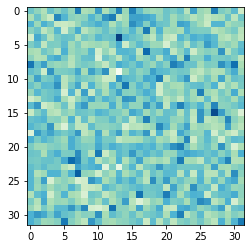

In [75]:
import matplotlib.pyplot as plt

def init_dataset(num_imgs):
    samples = []
    for i in range(num_imgs):
        noise_vec = np.random.normal(size=(3, 32, 32))
        # What label to give to these noise vectors?
        samples.append((torch.from_numpy(noise_vec).float(), 0))
        return samples

test = init_dataset(1000)

arr = test[0][0]

plt.imshow(arr.numpy()[0], cmap='GnBu_r')

In [82]:
class GaussianNoiseDataset(torch.utils.data.Dataset):
    def __init__(self, num_imgs, vision, classes=None, seed=1, im_size=(3, 32, 32), mean=0.0, std_dev=1.0):
        self.mean = mean
        self.std_dev = std_dev
        self.num_imgs = num_imgs
        self.im_size = im_size
        self.dataset = self._init_dataset()
        
        self.vision = vision
        
        np.random.seed(seed=seed)
        self.img_features = self._extract_img_features() # (dataset_size, embed_size)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, item):
        # get random images
        random_idxs = np.random.randint(low=0, high=self.__len__(), size=self.num_imgs)
        random_imgs = self.img_features[random_idxs]
        # get a random permutation of integers from 0 to num_imgs-1
        permutation = torch.randperm(self.num_imgs)

        # set the target image as the first random image
        sender_imgs = random_imgs[0].unsqueeze(dim=0)
        
        # permute random images for the receiver
        receiver_imgs = random_imgs[permutation]
        
        # set the label
        target = permutation.argmin()
        
        return sender_imgs, target, receiver_imgs
    
    def _init_dataset(self):
        samples = []
        for i in range(self.num_imgs):
            noise_vec = np.random.normal(loc=self.mean, scale=self.std_dev, size=self.im_size)
            # What label to give to these noise vectors?
            samples.append((torch.from_numpy(noise_vec).float(), 0))
        return samples

    def _extract_img_features(self):
        """
            We have to extract image features by making a forward pass through the pretrained vision model.
            We can't do it for all images at once as there's too many of them and we would run out of memory,
            so we do it in batches.
        """

        # read images from dataset into a single array
        imgs = [img for img, label in self.dataset]
        imgs = torch.stack(imgs)
        
        # if you run out of memory or your laptop freezes, decrease this number and try again
        VISION_BATCH_SIZE = 1000
        vision_loader = torch.utils.data.DataLoader(imgs, shuffle=False, batch_size=VISION_BATCH_SIZE, num_workers=0)

        # extract features from images with a vision model
        img_features = []
        for img in tqdm(vision_loader, desc="Extracting features in batches"):
            img = img.to(device)
            with torch.no_grad():
                img_features.append(self.vision(img))
        img_features = torch.cat(img_features)
        return img_features

print("Extract image features from test set")
testset_noise = GaussianNoiseDataset(num_imgs=1000, vision=vision)
testloader_noise = torch.utils.data.DataLoader(testset_noise, shuffle=False, batch_size=opts.batch_size, num_workers=0)

Extract image features from test set


Extracting features in batches: 100%|█████████████████████████| 1/1 [00:00<00:00, 71.79it/s]


In [ ]:
trainer = core.Trainer(
    game=game, optimizer=optimizer, train_data=trainloader,
    validation_data=testloader_noise, callbacks=callbacks)

trainer.train(n_epochs=opts.n_epochs)

{"loss": 0.05084223672747612, "acc": 0.9772800207138062, "length": 6.899099826812744, "mode": "train", "epoch": 1}
{"loss": 7.240937232971191, "acc": 0.0010000000474974513, "length": 4.014999866485596, "mode": "test", "epoch": 1}
{"loss": 0.06958307325839996, "acc": 0.9692400097846985, "length": 5.920519828796387, "mode": "train", "epoch": 2}
{"loss": 7.127333164215088, "acc": 0.0020000000949949026, "length": 4.994999885559082, "mode": "test", "epoch": 2}
{"loss": 0.053962964564561844, "acc": 0.9753400087356567, "length": 7.21835994720459, "mode": "train", "epoch": 3}
{"loss": 7.145680904388428, "acc": 0.003000000026077032, "length": 4.427000045776367, "mode": "test", "epoch": 3}
{"loss": 0.05607626959681511, "acc": 0.9751399755477905, "length": 7.476459980010986, "mode": "train", "epoch": 4}
{"loss": 6.735729694366455, "acc": 0.004999999888241291, "length": 5.079999923706055, "mode": "test", "epoch": 4}
{"loss": 0.07007385045289993, "acc": 0.9690200090408325, "length": 5.8580398559570

In [86]:
trainer.test(test_dataloader=testloader_noise)

AttributeError: 'Trainer' object has no attribute 'test'

In [ ]:
# class SignalGameDataset(torch.utils.data.Dataset):
#     def __init__(self, dataset, num_imgs, vision, classes=None, seed=1):
#         self.dataset = dataset
#         self.num_imgs = num_imgs
#         self.vision = vision
        
#         np.random.seed(seed=seed)
#         self.img_features = self._extract_img_features() # (dataset_size, embed_size)

#     def __len__(self):
#         return len(self.dataset)

#     def __getitem__(self, item):
#         # get random images
#         random_idxs = np.random.randint(low=0, high=self.__len__(), size=self.num_imgs)
#         random_imgs = self.img_features[random_idxs]
#         # get a random permutation of integers from 0 to num_imgs-1
#         permutation = torch.randperm(self.num_imgs)

#         # set the target image as the first random image
#         sender_imgs = random_imgs[0].unsqueeze(dim=0)
        
#         # permute random images for the receiver
#         receiver_imgs = random_imgs[permutation]
        
#         # set the label
#         target = permutation.argmin()
        
#         return sender_imgs, target, receiver_imgs

#     def _extract_img_features(self):
#         """
#             We have to have to extract image features by making a forward pass through the pretrained vision model.
#             We can't do it for all images at once as there's too many of them and we would run out of memory,
#             so we do it in batches.
#         """

#         # read images from dataset into a single array
#         imgs = [img for img, label in self.dataset]
#         imgs = torch.stack(imgs)
        
#         # if you run out of memory or your laptop freezes, decrease this number and try again
#         VISION_BATCH_SIZE = 1000
#         vision_loader = torch.utils.data.DataLoader(imgs, shuffle=False, batch_size=VISION_BATCH_SIZE, num_workers=0)

#         # extract features from images with a vision model
#         img_features = []
#         for img in tqdm(vision_loader, desc="Extracting features in batches"):
#             img = img.to(device)
#             with torch.no_grad():
#                 img_features.append(self.vision(img))
#         img_features = torch.cat(img_features)
#         return img_features


# class GaussianNoiseDataset(Dataset):
#     def __init__(self, dataset_size, game_size, vision, embedding_size, dataset_name, device, 
#                  sender_has_distractor=True, classes=None, im_size=(32,32), mean=0.0, std_dev=1.0):
#         self.mean = mean
#         self.std_dev = std_dev
#         self.dataset_name = dataset_name
#         self.dataset_size = dataset_size
#         self.im_size = im_size
#         self.dataset = self._init_dataset()
        
#         self.game_size = game_size
#         self.vision = vision
#         self.embedding_size = embedding_size
#         self.embeddings = self.pre_process_image_embeddings(16)
#         self.sender_has_distractor = sender_has_distractor
#         self.device = device

#     def _init_dataset(self):
#         samples = []
#         for i in range(self.dataset_size):
#             noise_vec = np.random.normal(loc=self.mean, scale=self.std_dev, size=self.im_size)
#             samples.append(noise_vec)
#         return samples
            
#     def pre_process_image_embeddings(self, batch_size):
#         if os.path.isfile(f"image_embeddings_{self.dataset_name}.pkl"):
#             return torch.load( open(f"image_embeddings_{self.dataset_name}.pkl", "rb" ) )
#         trainloader = torch.utils.data.DataLoader(self.dataset, shuffle=False,
#                                           batch_size=batch_size, num_workers=2)
        
#         image_embeddings = torch.zeros((len(self.dataset), self.embedding_size))
#         labels = torch.zeros(len(self.dataset))
#         for i, (x, y) in enumerate(tqdm(trainloader)):
#           x = x.to(device)
#           with torch.no_grad():
#             embedding = self.vision(x).cpu()
#           image_embeddings[i*batch_size:(i+1) * batch_size, :] = embedding
#           labels[i*batch_size:(i+1) * batch_size]  = y
        
#         torch.save(image_embeddings, open(f"image_embeddings_{self.dataset_name}.pkl", "wb" ))
#         return image_embeddings

#     def get_item_info(self, index):
#         image, classlabel = self.dataset[index]
#         return image, classlabel
    
#     def __len__(self):
#       return len(self.dataset)

#     def __getitem__(self, item):
#         dataset = self.embeddings
#         game_size = self.game_size
#         target_image = dataset[item]

#         indices = get_random_indices(item, range(self.__len__()), game_size-1)
#         images = [target_image] + [dataset[indice] for indice in indices]

#         sender_images = torch.stack(images, dim=0)

#         perm = torch.randperm(game_size)
#         receiver_imgs = sender_images[perm]
#         target = torch.argmin(perm)
        
#         if not self.sender_has_distractor:
#             sender_images = target_image

#         return sender_images, target, receiver_imgs

# if __name__ == '__main__':
#     testset_noise = GaussianNoiseDataset(dataset_size=1000, game_size=2, vision=vision, embedding_size=64, 
#                 dataset_name="gaussian_noise", device=device)

